In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE

## Load geometric information

In [2]:
from scipy.io import loadmat

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


## Load the neural network


In [3]:
from vae_models.convnext_models import *

beta=0
info = torch.load('../tb_logs/VAE_Evolver_[\'sqh\', \'cad\']_vel/beta=%.2g.ckpt' % beta)
print('Model Loss: %.3g' % info['loss'])
v_model = VAE_Evolver(**info['hparams'])
v_model.load_state_dict(info['state_dict'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

v_model.to(device)
v_model.eval();

Model Loss: 0.0318


## Integrate!

In [51]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition_utils import LeftRightSymmetrize

from torchdiffeq import odeint as odeint

def gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    if order == 0:
        return phi_x
    else:
        # f(x) = q(x) * phi(x) = q(x) * exp(p(x))
        # f'(x) = (q'(x) + q(x) * p'(x)) * phi(x)
        # p'(x) = -1 / sigma ** 2
        # Implement q'(x) + q(x) * p'(x) as a matrix operator and apply to the
        # coefficients of q(x)
        q = np.zeros(order + 1)
        q[0] = 1
        D = np.diag(exponent_range[1:], 1)  # D @ q(x) = q'(x)
        P = np.diag(np.ones(order)/-sigma2, -1)  # P @ q(x) = q(x) * p'(x)
        Q_deriv = D + P
        for _ in range(order):
            q = Q_deriv.dot(q)
        q = (x[:, None] ** exponent_range).dot(q)
        return q * phi_x


class ClosedFlyLoop(nn.Module):
    def __init__(self, YY, XX, v_model,
                 ds_int=None,
                 v_int=None,
                 sigma=3):
        super(ClosedFlyLoop, self).__init__()
        self.v_model = v_model.double()
        self.ds_int = ds_int
        self.v_int = v_int
        
        self.gamma_dv = nn.Parameter(
            torch.DoubleTensor([
                [1., 0.], 
                [0., 0.]
            ])[..., None, None], requires_grad=False)
        
        self.nDV = YY.shape[0]
        self.nAP = XX.shape[0]

        self.dAP = XX[1] - XX[0]
        self.dDV = YY[1] - YY[0]
        diff_kernel = gaussian_kernel1d(sigma=sigma, 
                                        order=1, 
                                        radius=int(4*sigma+0.5))
        diff_kernel = diff_kernel[::-1].copy() #REVERSE order as in scipy.ndimage.gaussian_filter1d
        diff_kernel = diff_kernel[None, None]
        self.diff_kernel = nn.Parameter(torch.DoubleTensor(diff_kernel), requires_grad=False)
        self.pad_size = self.diff_kernel.shape[-1] // 2
        
        Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        self.Gijk = nn.Parameter(torch.DoubleTensor(Gijk), requires_grad=False)
        
    def embryo_pad(self, x):
        '''
        x0 is a [..., H, W] field 
        We will pad it periodic in the DV direction (H) 
            and constant in the AP direction (W)
        '''
        c = x.shape[0:-2]
        h, w = x.shape[-2:]
        x = x.reshape([-1, h, w])
        
        ps = 2*self.pad_size
        
        #AP Pad - replicate
        x = F.pad(x, (ps, ps), mode='replicate')
        
        #DV pad - periodic
        x = x.permute(0, 2, 1)
        x = F.pad(x, (ps, ps), mode='circular')
        x = x.permute(0, 2, 1)
        
        x = x.reshape([*c, h+2*ps, w+2*ps])
        
        return x
    
    def gradient(self, x0):
        c = x0.shape[0:-2]
        h, w = x0.shape[-2:]
        
        x = x0.reshape([-1, h, w])
        x = self.embryo_pad(x)
        
        ps = self.pad_size
        hp, wp = x.shape[-2:]

        dY = x.permute(0, 2, 1).reshape([-1, 1, h+4*ps])
        dY = F.conv1d(dY, self.diff_kernel) / self.dDV
        dY = dY.reshape([-1, w+4*ps, h+2*ps]).permute(0, 2, 1)
        dY = dY[:, ps:-ps, 2*ps:-2*ps].reshape([*c, h, w])
        
        dX = x.reshape([-1, 1, w+4*ps])
        dX = F.conv1d(dX, self.diff_kernel) / self.dAP
        dX = dX.reshape([-1, h+4*ps, w+2*ps])
        dX = dX[:, 2*ps:-2*ps, ps:-ps:].reshape([*c, h, w])
        
        return torch.stack([dY, dX], dim=-1)
    
    def covariant_gradient(self, x0):
        grad_x = self.gradient(x0)
        if len(x0.shape) == 3: #Vector
            grad_x += torch.einsum('yxijk,kyx->iyxj', self.Gijk, x0)
        elif len(x0.shape) == 4: #Tensor
            grad_x += torch.einsum('yxikl,ljyx->ijyxk', self.Gijk, x0) + \
                      torch.einsum('yxjkl,ilyx->ijyxk', self.Gijk, x0)
        return grad_x
    
    def get_velocity(self, t, y):
        if self.v_int is None: 
            v, _ = VAE.forward(self.v_model, y.reshape([-1, *y.shape[-3:]]))
        
        else:
            t0 = t.cpu().numpy()
            v = self.v_int(t0)
            v = torch.from_numpy(v).to(y.device)
            
        #Left-right symmetrize
        v_lr = torch.flip(v, (-2,))
        v_lr[..., 0, :, :] *= -1
        return 0.5 * (v + v_lr)
        
    def forward(self, t, y):
        #Get myosin and cadherin
        m = y[:4].reshape([2, 2, self.nDV, self.nAP])
        c = y[4:].squeeze()

        #Compute flow from myosin/cadherin
        v = self.get_velocity(t, y).squeeze()
        
        #Sources
        ds = torch.from_numpy(self.ds_int(t.item())).to(m.device)
        dv = self.gamma_dv[:, :, None, None]

        #Gradients
        d1_m = self.covariant_gradient(m)
        d1_c = self.covariant_gradient(c)
        d1_v = self.covariant_gradient(v)

        #Flow derivative tensors
        O = -0.5 * (torch.einsum('iyxj->ijyx', d1_v) - \
                    torch.einsum('jyxi->ijyx', d1_v))
        E = 0.5 * (torch.einsum('iyxj->ijyx', d1_v) + \
                   torch.einsum('jyxi->ijyx', d1_v))

        #Active/Passive strain decomposition
        deviatoric = m - 0.5 * torch.einsum('kkyx,ij->ijyx', 
                                            m, torch.eye(2, device=m.device))

        m_0 = torch.linalg.norm(m, dim=(0, 1), keepdims=True).mean(dim=(2, 3), keepdims=True)
        dev_mag = torch.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

        devE = torch.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

        E_active = E - torch.sign(devE) * devE * deviatoric / dev_mag**2
        E_active = 0.5 * E_active * dev_mag / m_0 
        E_passive = E - E_active

        mE = torch.einsum('ikyx,kjyx->ijyx', m, E_passive) + \
             torch.einsum('ikyx,kjyx->ijyx', E_passive, m) 
        
        #Cadherin Dynamics
        cdot =  -1.000 * torch.einsum('iyx,yxi->yx', v, d1_c)
        cdot += -0.025 * c
        cdot += -0.2 * torch.einsum('yx,iyxi->yx', c, d1_v)
        cdot +=  0.25 * ds

        trm = torch.einsum('kkyx->yx', m)[None, None]

        #Myosin dynamics
        mdot =  -1.000 * torch.einsum('kyx,ijyxk->ijyx', v, d1_m)
        mdot -= +1.000 * torch.einsum('ikyx,kjyx->ijyx', O, m)
        mdot -= -1.000 * torch.einsum('ikyx,kjyx->ijyx', m, O)
        mdot += -0.2 * m
        mdot += (3. - 1. * c) * mE
        mdot += 0.2 * trm * self.gamma_dv
        mdot += 0.11 * trm * m

        ydot = torch.cat([
            mdot.reshape([4, self.nDV, self.nAP]),
            cdot.reshape([1, self.nDV, self.nAP]),
        ])

        return ydot
    
def integrate(m0, c0, v_model, gamma_d0, times, YY, XX, v0=None):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field determined by ML
    and two source fields
    ''' 
        
    #Set up interpolators for control fields
    ds_int = interp1d(times, gamma_d0, axis=0, fill_value='extrapolate')
    
    if v0 is None:
        v_int = None
    else:
        v_int = interp1d(times, v0, axis=0, fill_value='extrapolate')
    
    model = ClosedFlyLoop(YY, XX, v_model, 
                          ds_int=ds_int, v_int=v_int)
    model.to(device)


    y0 = np.concatenate([
        m0.reshape([4, *m0.shape[-2:]]),
        c0.reshape([1, *c0.shape[-2:]]),
    ])
    y0 = torch.from_numpy(y0).to(device)
    t = torch.DoubleTensor(times).to(device)
    
    with torch.no_grad():
        y = odeint(model, y0, t, method='rk4')
        m = y[:, :4].reshape([-1, 2, 2, *y.shape[-2:]]).cpu().numpy()
        c = y[:, 4:].cpu().numpy()
        v = model.get_velocity(t, y).cpu().numpy()
    
    return model, (m, c, v, times)

'''
Collect initial conditions - m, c, v, gamma_d, gamma_dv, and time
'''
with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    sigma = 10
  
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    c0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...][()]
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    

model, (m, c, v, t) = integrate(
    m0[0], c0[0], v_model,
    gamma_d, t0, dv, ap)
print(m.shape, c.shape, v.shape, t.shape)

(21, 2, 2, 236, 200) (21, 1, 236, 200) (21, 2, 236, 200) (21,)


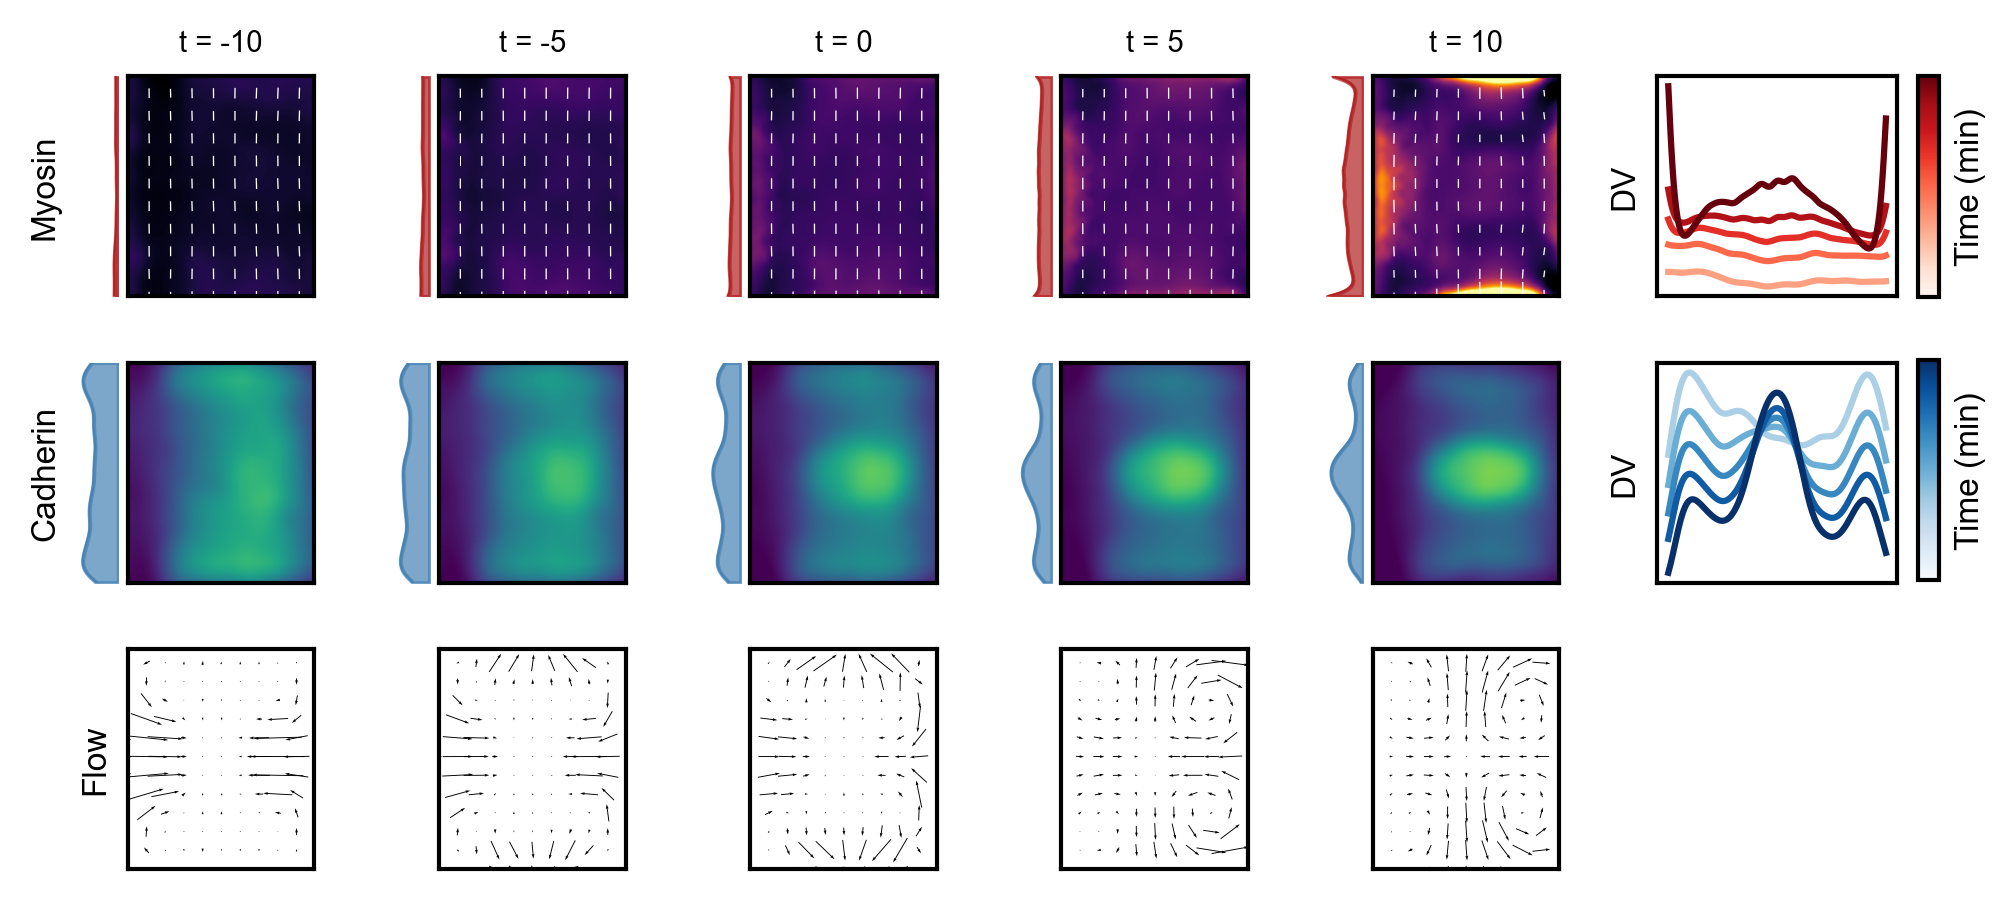

In [52]:
from matplotlib.colors import Normalize

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    if len(z.shape) > 3:
        plot_tensor2D(ax, z, **kwargs)
    else:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=6, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))
        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + 20)/ (np.max(t) + 20))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + 20)/ (np.max(t) + 20))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
        ax1[2, -1].set_visible(False)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for i in range(ax1.shape[0]):
        for j in range(ax1.shape[1]-1):
            ax1[i, j].set_aspect('equal')
        
mnorm = np.linalg.norm(m0, axis=(1, 2))
mmin = np.min(mnorm)
mmax = np.max(mnorm)
cmin = np.min(c0)
cmax = np.max(c0)
mask = np.s_[..., 20:-20, 0:-25]

plot(m, c, v, t, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax, mask=mask)
#plot(m0, c0, v0, t0, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax)

(21,) (21,)


Text(0, 0.5, 'Error Rate')

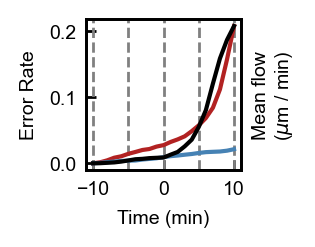

In [53]:
#Demonstrate ensemble of cell trajectories
from utils.plot_utils import *

plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 7

fig, ax = plt.subplots(figsize=(1., 1.))

for tt in [-10, -5, 0, 5, 10]:
    ax.axvline(tt, color='grey', linestyle='--', linewidth=1)


ax2 = ax.twinx()
ax2.plot(t, np.linalg.norm(v, axis=1).mean(axis=(1, 2)), color='black')
ax.set_xticks([-10, 0, 10])
ax.set_xlabel('Time (min)')
ax2.set_ylabel('Mean flow\n($\mu$m / min)')

    
res_m = mean_norm_residual(m0[mask], m[mask]).mean(axis=(1, 2))
res_c = residual(c0[mask], c[mask]).mean(axis=(1, 2))

print(res_m.shape, res_c.shape)
ax2.set_yticks([])

ax.plot(t, res_m, color='firebrick')
ax.plot(t, res_c, color='steelblue')
ax.set_ylabel('Error Rate')